### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-18/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Con ventaneo y data augmentation
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### InceptionV3
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (299, 299) #ancho, alto
  fs = 250
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((528,4,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :, 0] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 1] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 2] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como a
      print(i)
  return datos

In [12]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
0
100
200


In [13]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

124.52351832617315
88.18918136153654
0.0006962254188471109
0.00013698288039382033
1.171795813706635
1.1849465019572498


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 125.0
x_test /= 125.0

In [16]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99618816
0.7055134
5.5698033e-06
1.095863e-06
0.009374359
0.009479575


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=x_train.shape[1:])

In [0]:
# operación global de agrupación máxima para datos espaciales.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# entrenar solo las capas superiores (top) que se inicializaron aleatoriamente
# congelar todas las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [0]:
# debe hacerse después de configurar las capas como no entrenables
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/40
 - 12s - loss: 1.5193 - accuracy: 0.2569 - val_loss: 1.3858 - val_accuracy: 0.2917
Epoch 2/40
 - 4s - loss: 1.3970 - accuracy: 0.2986 - val_loss: 1.4429 - val_accuracy: 0.2535
Epoch 3/40
 - 6s - loss: 1.4007 - accuracy: 0.2917 - val_loss: 1.4215 - val_accuracy: 0.2604
Epoch 4/40
 - 6s - loss: 1.3221 - accuracy: 0.3368 - val_loss: 1.4118 - val_accuracy: 0.2569
Epoch 5/40
 - 6s - loss: 1.2979 - accuracy: 0.3785 - val_loss: 1.3898 - val_accuracy: 0.2535
Epoch 6/40
 - 6s - loss: 1.3185 - accuracy: 0.3611 - val_loss: 1.3717 - val_accuracy: 0.3021
Epoch 7/40
 - 6s - loss: 1.2844 - accuracy: 0.3750 - val_loss: 1.4615 - val_accuracy: 0.2465
Epoch 8/40
 - 6s - loss: 1.2761 - accuracy: 0.3681 - val_loss: 1.3799 - val_accuracy: 0.2847
Epoch 9/40
 - 6s - loss: 1.2866 - accuracy: 0.3889 - val_loss: 1.4609 - val_accuracy: 0.2535
Epoch 10/40
 - 6s - loss: 1.2664 - accuracy: 0.4028 - val_loss: 1.3943 - val_accuracy: 0.2639
Epoch 11/40
 - 6s - loss: 1.2398 - accuracy: 0.4201 - v

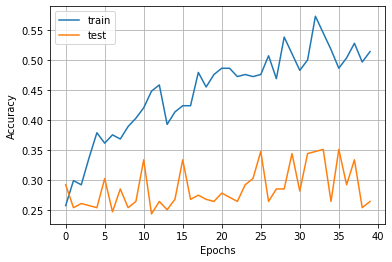

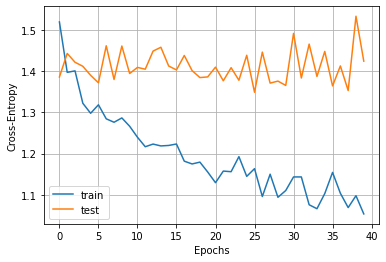


Resultados:
loss: [1.4242144425710042]
accuracy: [0.2638888955116272]
kappa: [0.01851851851851849]


In [22]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=40,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [23]:
# en este punto las capas superiores (top) estan entrenadas
# podemos empezar a ajustar el fine tuning
# congelaremos n capas inferiores (bottom)
# entrenar las capas superiores (top) restantes
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
# entrenar los 2 bloques de inicio principales
# congelaremos las primeras 249 capas y descongelaremos el resto
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
# recompilar el modelo
model.compile(optimizer = SGD(lr=1e-4, momentum=0.9), #lr=0.0001, momentum=0.9
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/400
 - 13s - loss: 1.0289 - accuracy: 0.5278 - val_loss: 1.4188 - val_accuracy: 0.2639
Epoch 2/400
 - 4s - loss: 1.0261 - accuracy: 0.5486 - val_loss: 1.4117 - val_accuracy: 0.2708
Epoch 3/400
 - 6s - loss: 0.9696 - accuracy: 0.6146 - val_loss: 1.4119 - val_accuracy: 0.2743
Epoch 4/400
 - 6s - loss: 0.9881 - accuracy: 0.6285 - val_loss: 1.4122 - val_accuracy: 0.2743
Epoch 5/400
 - 6s - loss: 0.9430 - accuracy: 0.6562 - val_loss: 1.4169 - val_accuracy: 0.2639
Epoch 6/400
 - 6s - loss: 0.9975 - accuracy: 0.6319 - val_loss: 1.4217 - val_accuracy: 0.2674
Epoch 7/400
 - 6s - loss: 0.9432 - accuracy: 0.6493 - val_loss: 1.4280 - val_accuracy: 0.2639
Epoch 8/400
 - 6s - loss: 0.9572 - accuracy: 0.6215 - val_loss: 1.4387 - val_accuracy: 0.2639
Epoch 9/400
 - 6s - loss: 0.9446 - accuracy: 0.6354 - val_loss: 1.4477 - val_accuracy: 0.2604
Epoch 10/400
 - 6s - loss: 0.9342 - accuracy: 0.6215 - val_loss: 1.4529 - val_accuracy: 0.2639
Epoch 11/400
 - 6s - loss: 0.9708 - accuracy:

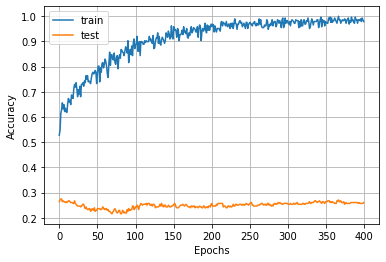

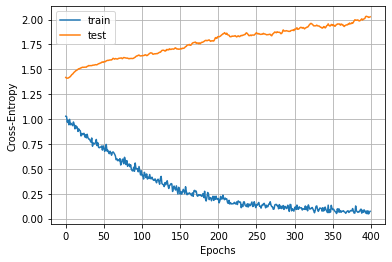


Resultados:
loss: [2.0278122822443643]
accuracy: [0.2604166567325592]
kappa: [0.01388888888888884]


In [26]:
# entrenamos nuestro modelo nuevamente
# fine tuning a 2 bloques (top) superiores de inception
# y a las capas superiores (top)
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [28]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.2604
std: (+/- 0.0000)
Mean Kappa: 0.0139
std: (+/- 0.0000)
Max Accuracy: 0.2604
Max Kappa: 0.0139
